In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import scrublet as scr
import anndata
import scanpy.external as sce
import scvelo as scv
import infercnvpy as cnv
import os
import sklearn
import bbknn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

np.random.seed(0)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.8.0
scanpy      1.9.1
-----
Cython                      0.29.28
PIL                         9.0.1
annoy                       NA
asttokens                   NA
backcall                    0.2.0
bbknn                       NA
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.4
cffi                        1.15.0
click                       8.0.4
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython                      0.29.28
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
distributed                 2022.2.1
executing                   0.8.3
fsspec                      2022.02.0
google                      NA
gtfparse                    1.2.1
h5py                        3.6.0
igr

In [38]:
adata = sc.read_h5ad('./cache/scRNA_celltype.h5ad')

In [51]:
adata.raw.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT',
       'A4GNT', 'AAAS', 'AACS',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=25444)

In [52]:
adata.var

gene_ids-0  feature_types-0  n_cells-0       gene_ids-1  \
A2M      ENSG00000175899  Gene Expression       91.0  ENSG00000175899   
A2M-AS1  ENSG00000245105  Gene Expression       33.0  ENSG00000245105   
AATK     ENSG00000181409  Gene Expression      213.0  ENSG00000181409   
ABAT     ENSG00000183044  Gene Expression      184.0  ENSG00000183044   
ABCA1    ENSG00000165029  Gene Expression      541.0  ENSG00000165029   
...                  ...              ...        ...              ...   
ZNF683   ENSG00000176083  Gene Expression       48.0  ENSG00000176083   
ZNF763   ENSG00000197054  Gene Expression       18.0  ENSG00000197054   
ZNF80    ENSG00000174255  Gene Expression       20.0  ENSG00000174255   
ZNF891   ENSG00000214029  Gene Expression      103.0  ENSG00000214029   
ZSWIM6   ENSG00000130449  Gene Expression      726.0  ENSG00000130449   

         feature_types-1  n_cells-1       gene_ids-2  feature_types-2  \
A2M      Gene Expression     1059.0  ENSG00000175899  Gene Expression   
A2M-AS1  Gene Expression      103.0  ENSG00000245105  Gene Expression   
AATK     Gene Expression      266.0  ENSG00000181409  Gene Expression   
ABAT     Gene Expression      314.0  ENSG00000183044  Gene Expression   
ABCA1    Gene Expression     1267.0  ENSG00000165029  Gene Expression   
...                  ...        ...              ...              ...   
ZNF683   Gene Expression      880.0  ENSG00000176083  Gene Expression   
ZNF763   Gene Expression       33.0  ENSG00000197054  Gene Expression   
ZNF80    Gene Expression      119.0  ENSG00000174255  Gene Expression   
ZNF891   Gene Expression      600.0  ENSG00000214029  Gene Expression   
ZSWIM6   Gene Expression     2023.0  ENSG00000130449  Gene Expression   

         n_cells-2       gene_ids-3  ... n_cells-7       gene_ids-8  \
A2M           90.0  ENSG00000175899  ...     233.0  ENSG00000175899   
A2M-AS1       46.0  ENSG00000245105  ...     214.0  ENSG00000245105   
AATK          61.0  ENSG00000181409  ...       7.0  ENSG00000181409   
ABAT         103.0  ENSG00000183044  ...      73.0  ENSG00000183044   
ABCA1        645.0  ENSG00000165029  ...      62.0  ENSG00000165029   
...            ...              ...  ...       ...              ...   
ZNF683        32.0  ENSG00000176083  ...      10.0  ENSG00000176083   
ZNF763        33.0  ENSG00000197054  ...      21.0  ENSG00000197054   
ZNF80         19.0  ENSG00000174255  ...      24.0  ENSG00000174255   
ZNF891       445.0  ENSG00000214029  ...     102.0  ENSG00000214029   
ZSWIM6       509.0  ENSG00000130449  ...     126.0  ENSG00000130449   

         feature_types-8 n_cells-8  highly_variable     means dispersions  \
A2M      Gene Expression     829.0             True  0.341871    2.820835   
A2M-AS1  Gene Expression    1707.0             True  0.201404    1.807075   
AATK     Gene Expression      41.0             True  0.055466    2.071158   
ABAT     Gene Expression     293.0             True  0.090134    1.620865   
ABCA1    Gene Expression     243.0             True  0.431940    2.270900   
...                  ...       ...              ...       ...         ...   
ZNF683   Gene Expression     970.0             True  0.314768    2.465709   
ZNF763   Gene Expression      57.0             True  0.016885    1.783601   
ZNF80    Gene Expression     184.0             True  0.060800    2.020616   
ZNF891   Gene Expression     748.0             True  0.223411    1.731365   
ZSWIM6   Gene Expression     532.0             True  0.289442    1.825670   

         dispersions_norm          mean       std  
A2M              2.296135  5.171360e-11  0.445450  
A2M-AS1          0.821679  1.455386e-12  0.355597  
AATK             1.259380 -5.614315e-11  0.180455  
ABAT             0.513047  9.227958e-12  0.231704  
ABCA1            1.255066  2.857400e-11  0.521882  
...                   ...           ...       ...  
ZNF683           1.913323 -1.108446e-10  0.439686  
ZNF763           0.782773 -4.908007e-12  0.099084  
ZNF80         

In [53]:
df = pd.read_csv('gene_infor.csv')

In [54]:
df

Unnamed: 0       V1       gene_ids-0  feature_types-0  n_cells-0  \
0              1      A2M  ENSG00000175899  Gene Expression       91.0   
1              2  A2M-AS1  ENSG00000245105  Gene Expression       33.0   
2              3     AATK  ENSG00000181409  Gene Expression      213.0   
3              4     ABAT  ENSG00000183044  Gene Expression      184.0   
4              5    ABCA1  ENSG00000165029  Gene Expression      541.0   
...          ...      ...              ...              ...        ...   
2631        2632   ZNF683  ENSG00000176083  Gene Expression       48.0   
2632        2633   ZNF763  ENSG00000197054  Gene Expression       18.0   
2633        2634    ZNF80  ENSG00000174255  Gene Expression       20.0   
2634        2635   ZNF891  ENSG00000214029  Gene Expression      103.0   
2635        2636   ZSWIM6  ENSG00000130449  Gene Expression      726.0   

           gene_ids-1  feature_types-1  n_cells-1       gene_ids-2  \
0     ENSG00000175899  Gene Expression     1059.0  ENSG00000175899   
1     ENSG00000245105  Gene Expression      103.0  ENSG00000245105   
2     ENSG00000181409  Gene Expression      266.0  ENSG00000181409   
3     ENSG00000183044  Gene Expression      314.0  ENSG00000183044   
4     ENSG00000165029  Gene Expression     1267.0  ENSG00000165029   
...               ...              ...        ...              ...   
2631  ENSG00000176083  Gene Expression      880.0  ENSG00000176083   
2632  ENSG00000197054  Gene Expression       33.0  ENSG00000197054   
2633  ENSG00000174255  Gene Expression      119.0  ENSG00000174255   
2634  ENSG00000214029  Gene Expression      600.0  ENSG00000214029   
2635  ENSG00000130449  Gene Expression     2023.0  ENSG00000130449   

      feature_types-2  ...     means dispersions dispersions_norm  \
0     Gene Expression  ...  0.341871    2.820835         2.296135   
1     Gene Expression  ...  0.201404    1.807075         0.821679   
2     Gene Expression  ...  0.055466    2.071158         1.259380   
3     Gene Expression  ...  0.090134    1.620865         0.513047   
4     Gene Expression  ...  0.431940    2.270900         1.255066   
...               ...  ...       ...         ...              ...   
2631  Gene Expression  ...  0.314768    2.465709         1.913323   
2632  Gene Expression  ...  0.016885    1.783601         0.782773   
2633  Gene Expression  ...  0.060800    2.020616         1.175610   
2634  Gene Expression  ...  0.223411    1.731365         0.696195   
2635  Gene Expression  ...  0.289442    1.825670         0.852499   

              mean       std   SYMBOL        biotypes    chr        start  \
0     5.171360e-11  0.445450      A2M  protein_coding  chr12    9067664.0   
1     1.455386e-12  0.355597  A2M-AS1          lncRNA  chr12    9065163.0   
2    -5.614315e-11  0.180455     AATK  protein_coding  chr17   81110487.0   
3     9.227958e-12  0.231704     ABAT  protein_coding  chr16    8674596.0   
4     2.857400e-11  0.521882    ABCA1  protein_coding   chr9  104781006.0   
...            ...       ...      ...             ...    ...          ...   
2631 -1.108446e-10  0.439686   ZNF683  protein_coding   chr1   26361634.0   
2632 -4.908007e-12  0.099084   ZNF763  protein_coding  chr19   11965037.0   
2633 -1.675938e-11  0.190633    ZNF80  protein_coding   chr3  114234631.0   
2634 -1.537993e-12  0.369597   ZNF891  protein_coding  chr12  133106817.0   
2635 -3.073724e-11  0.418512   ZSWIM6  protein_coding   chr5   61332258.0   

              end  
0       9116229.0  
1       9068689.0  
2      81166221.0  
3       8784575.0  
4     104928155.0  
...           ...  
2631   26374522.0  
2632   11980617.0  
2633  114237578.0  
2634  133130473.0  
2635   61546172.0  

[2636 rows x 40 columns]

In [55]:
adata.var['chromosome'] = df['chr'].to_list()
adata.var['start'] = df['start'].to_list()
adata.var['end'] = df['end'].to_list()

In [56]:
adata = adata[: , adata.var.chromosome.notna()]

In [59]:
adata.obs

n_genes          ID Sample   Tissue metastasis_status  \
AAACCCACAACAACAA-1      352  GSM5004180    PT1  Gastric           Primary   
AAACCCAGTCAAAGTA-1     4415  GSM5004180    PT1  Gastric           Primary   
AAACCCAGTGGATACG-1      492  GSM5004180    PT1  Gastric           Primary   
AAACCCATCGTTCCCA-1      323  GSM5004180    PT1  Gastric           Primary   
AAACGAAAGCTGTTCA-1      771  GSM5004180    PT1  Gastric           Primary   
...                     ...         ...    ...      ...               ...   
TTTGTTGGTGTCCGGT-1     1405  GSM5004189    Li2    Liver        Metastasis   
TTTGTTGTCGCGCTGA-1     1068  GSM5004189    Li2    Liver        Metastasis   
TTTGTTGTCGTAGGAG-1     1034  GSM5004189    Li2    Liver        Metastasis   
TTTGTTGTCTAGAACC-1     1186  GSM5004189    Li2    Liver        Metastasis   
TTTGTTGTCTTTCCGG-1     1397  GSM5004189    Li2    Liver        Metastasis   

                    percent_mito batch  n_counts  log_counts  doublet_scores  \
AAACCCACAACAACAA-1      0.008205     0     975.0    6.882438        0.013535   
AAACCCAGTCAAAGTA-1      0.076083     0   16022.0    9.681718        0.045936   
AAACCCAGTGGATACG-1      0.009602     0    1458.0    7.284821        0.007528   
AAACCCATCGTTCCCA-1      0.009579     0     522.0    6.257668        0.006400   
AAACGAAAGCTGTTCA-1      0.005300     0    2264.0    7.724888        0.008459   
...                          ...   ...       ...         ...             ...   
TTTGTTGGTGTCCGGT-1      0.134015     8    3813.0    8.246172        0.104972   
TTTGTTGTCGCGCTGA-1      0.086989     8    2667.0    7.888710        0.113817   
TTTGTTGTCGTAGGAG-1      0.043174     8    2432.0    7.796469        0.115385   
TTTGTTGTCTAGAACC-1      0.054685     8    2615.0    7.869020        0.029126   
TTTGTTGTCTTTCCGG-1      0.069156     8    3615.0    8.192847        0.042613   

                    ...  cluster_0.8 cluster_0.9 cluster_1.0 cluster_1.1  \
AAACCCACAACAACAA-1  ...            7           8           9           8   
AAACCCAGTCAAAGTA-1  ...           15          15          14          14   
AAACCCAGTGGATACG-1  ...            7           8           9           8   
AAACCCATCGTTCCCA-1  ...            7           8           9           8   
AAACGAAAGCTGTTCA-1  ...            7           8           9           8   
...                 ...          ...         ...         ...         ...   
TTTGTTGGTGTCCGGT-1  ...            9          10           6           6   
TTTGTTGTCGCGCTGA-1  ...            0           0           1           0   
TTTGTTGTCGTAGGAG-1  ...            2           2           2           2   
TTTGTTGTCTAGAACC-1  ...            2           2           2           2   
TTTGTTGTCTTTCCGG-1  ...            2           2           2           2   

                   cluster_1.2 cluster_1.3 cluster_1.4 cluster_1.5  \
AAACCCACAACAACAA-1           7           8           7           7   
AAACCCAGTCAAAGTA-1          12          12          10          10   
AAACCCAGTGGATACG-1           7           8           7           7   
AAACCCATCGTTCCCA-1           7           8           7           7   
AAACGAAAGCTGTTCA-1           7           8           7           7   
...                        ...         ...         ...         ...   
TTTGTTGGTGTCCGGT-1           9           6           8           4   
TTTGTTGTCGCGCTGA-1           0           0           0           0   
TTTGTTGTCGTAGGAG-1           2           2           1           1   
TTTGTTGTCTAGAACC-1           2           2           1           1   
TTTGTTGTCTTTCCGG-1           2           2           1           1   

                               barcode    cell type  
AAACCCACAACAACAA-1  AAACCCACAACAACAA-1  Neutrophils  
AAACCCAGTCAAAGTA-1  AAACCCAGTCAAAGTA-1       T cell  
AAACCCAGTGGATACG-1  AAACCCAGTGGATACG-1  Neutrophils  
AAACCCATCGTTCCCA-1  AAACCCATCGTTCCCA-1  Neutrophils  
AAACGAAAGCTGTTCA-1  AAACGAAAGCTGTTCA-1  Neutrophils  
...                                ...          ...  
TT

In [57]:
adata.var

gene_ids-0  feature_types-0  n_cells-0       gene_ids-1  \
A2M      ENSG00000175899  Gene Expression       91.0  ENSG00000175899   
A2M-AS1  ENSG00000245105  Gene Expression       33.0  ENSG00000245105   
AATK     ENSG00000181409  Gene Expression      213.0  ENSG00000181409   
ABAT     ENSG00000183044  Gene Expression      184.0  ENSG00000183044   
ABCA1    ENSG00000165029  Gene Expression      541.0  ENSG00000165029   
...                  ...              ...        ...              ...   
ZNF683   ENSG00000176083  Gene Expression       48.0  ENSG00000176083   
ZNF763   ENSG00000197054  Gene Expression       18.0  ENSG00000197054   
ZNF80    ENSG00000174255  Gene Expression       20.0  ENSG00000174255   
ZNF891   ENSG00000214029  Gene Expression      103.0  ENSG00000214029   
ZSWIM6   ENSG00000130449  Gene Expression      726.0  ENSG00000130449   

         feature_types-1  n_cells-1       gene_ids-2  feature_types-2  \
A2M      Gene Expression     1059.0  ENSG00000175899  Gene Expression   
A2M-AS1  Gene Expression      103.0  ENSG00000245105  Gene Expression   
AATK     Gene Expression      266.0  ENSG00000181409  Gene Expression   
ABAT     Gene Expression      314.0  ENSG00000183044  Gene Expression   
ABCA1    Gene Expression     1267.0  ENSG00000165029  Gene Expression   
...                  ...        ...              ...              ...   
ZNF683   Gene Expression      880.0  ENSG00000176083  Gene Expression   
ZNF763   Gene Expression       33.0  ENSG00000197054  Gene Expression   
ZNF80    Gene Expression      119.0  ENSG00000174255  Gene Expression   
ZNF891   Gene Expression      600.0  ENSG00000214029  Gene Expression   
ZSWIM6   Gene Expression     2023.0  ENSG00000130449  Gene Expression   

         n_cells-2       gene_ids-3  ... n_cells-8  highly_variable     means  \
A2M           90.0  ENSG00000175899  ...     829.0             True  0.341871   
A2M-AS1       46.0  ENSG00000245105  ...    1707.0             True  0.201404   
AATK          61.0  ENSG00000181409  ...      41.0             True  0.055466   
ABAT         103.0  ENSG00000183044  ...     293.0             True  0.090134   
ABCA1        645.0  ENSG00000165029  ...     243.0             True  0.431940   
...            ...              ...  ...       ...              ...       ...   
ZNF683        32.0  ENSG00000176083  ...     970.0             True  0.314768   
ZNF763        33.0  ENSG00000197054  ...      57.0             True  0.016885   
ZNF80         19.0  ENSG00000174255  ...     184.0             True  0.060800   
ZNF891       445.0  ENSG00000214029  ...     748.0             True  0.223411   
ZSWIM6       509.0  ENSG00000130449  ...     532.0             True  0.289442   

        dispersions  dispersions_norm          mean       std  chromosome  \
A2M        2.820835          2.296135  5.171360e-11  0.445450       chr12   
A2M-AS1    1.807075          0.821679  1.455386e-12  0.355597       chr12   
AATK       2.071158          1.259380 -5.614315e-11  0.180455       chr17   
ABAT       1.620865          0.513047  9.227958e-12  0.231704       chr16   
ABCA1      2.270900          1.255066  2.857400e-11  0.521882        chr9   
...             ...               ...           ...       ...         ...   
ZNF683     2.465709          1.913323 -1.108446e-10  0.439686        chr1   
ZNF763     1.783601          0.782773 -4.908007e-12  0.099084       chr19   
ZNF80      2.020616          1.175610 -1.675938e-11  0.190633        chr3   
ZNF891     1.731365          0.696195 -1.537993e-12  0.369597       chr12   
ZSWIM6     1.825670          0.852499 -3.073724e-11  0.418512        chr5   

               start          end  
A2M        9067664.0    9116229.0  
A2M-AS1    9065163.0    9068689.0  
AATK      81110487.0   81166221.0  
ABAT       8674596.0    8784575.0  
ABCA1    104781006.0  104928155.0  
...              ...          ...  
ZNF683    26361634.0   26374522.0  
ZNF763    11965037.0   11980617.0  
ZNF80    114234631.0  114237578.0  
ZN

In [58]:
?cnv.tl.infercnv

Signature:
cnv.tl.infercnv(
    adata: anndata._core.anndata.AnnData,
    *,
    reference_key: Optional[str] = None,
    reference_cat: Union[NoneType, str, Sequence[str]] = None,
    reference: Optional[numpy.ndarray] = None,
    lfc_clip: float = 3,
    window_size: int = 100,
    step: int = 10,
    dynamic_threshold: Optional[float] = 1.5,
    exclude_chromosomes: Optional[Sequence[str]] = ('chrX', 'chrY'),
    chunksize: int = 5000,
    n_jobs: Optional[int] = None,
    inplace: bool = True,
    layer: Optional[str] = None,
    key_added: str = 'cnv',
) -> Optional[Tuple[dict, scipy.sparse.csr.csr_matrix]]
Docstring:
Infer Copy Number Variation (CNV) by averaging gene expression over genomic
regions.

This method is heavily inspired by `infercnv <https://github.com/broadinstitute/inferCNV/>`_
but more computationally efficient. The method is described in more detail
in on the :ref:`infercnv-method` page.

There, you can also find instructions on how to :ref:`prepare input data <i

In [60]:
cnv.tl.infercnv(
    adata,
    reference_key="Tissue",
    reference_cat=[
        "Normal",
    ],
    window_size=250,
)

  0%|          | 0/9 [00:00<?, ?it/s]

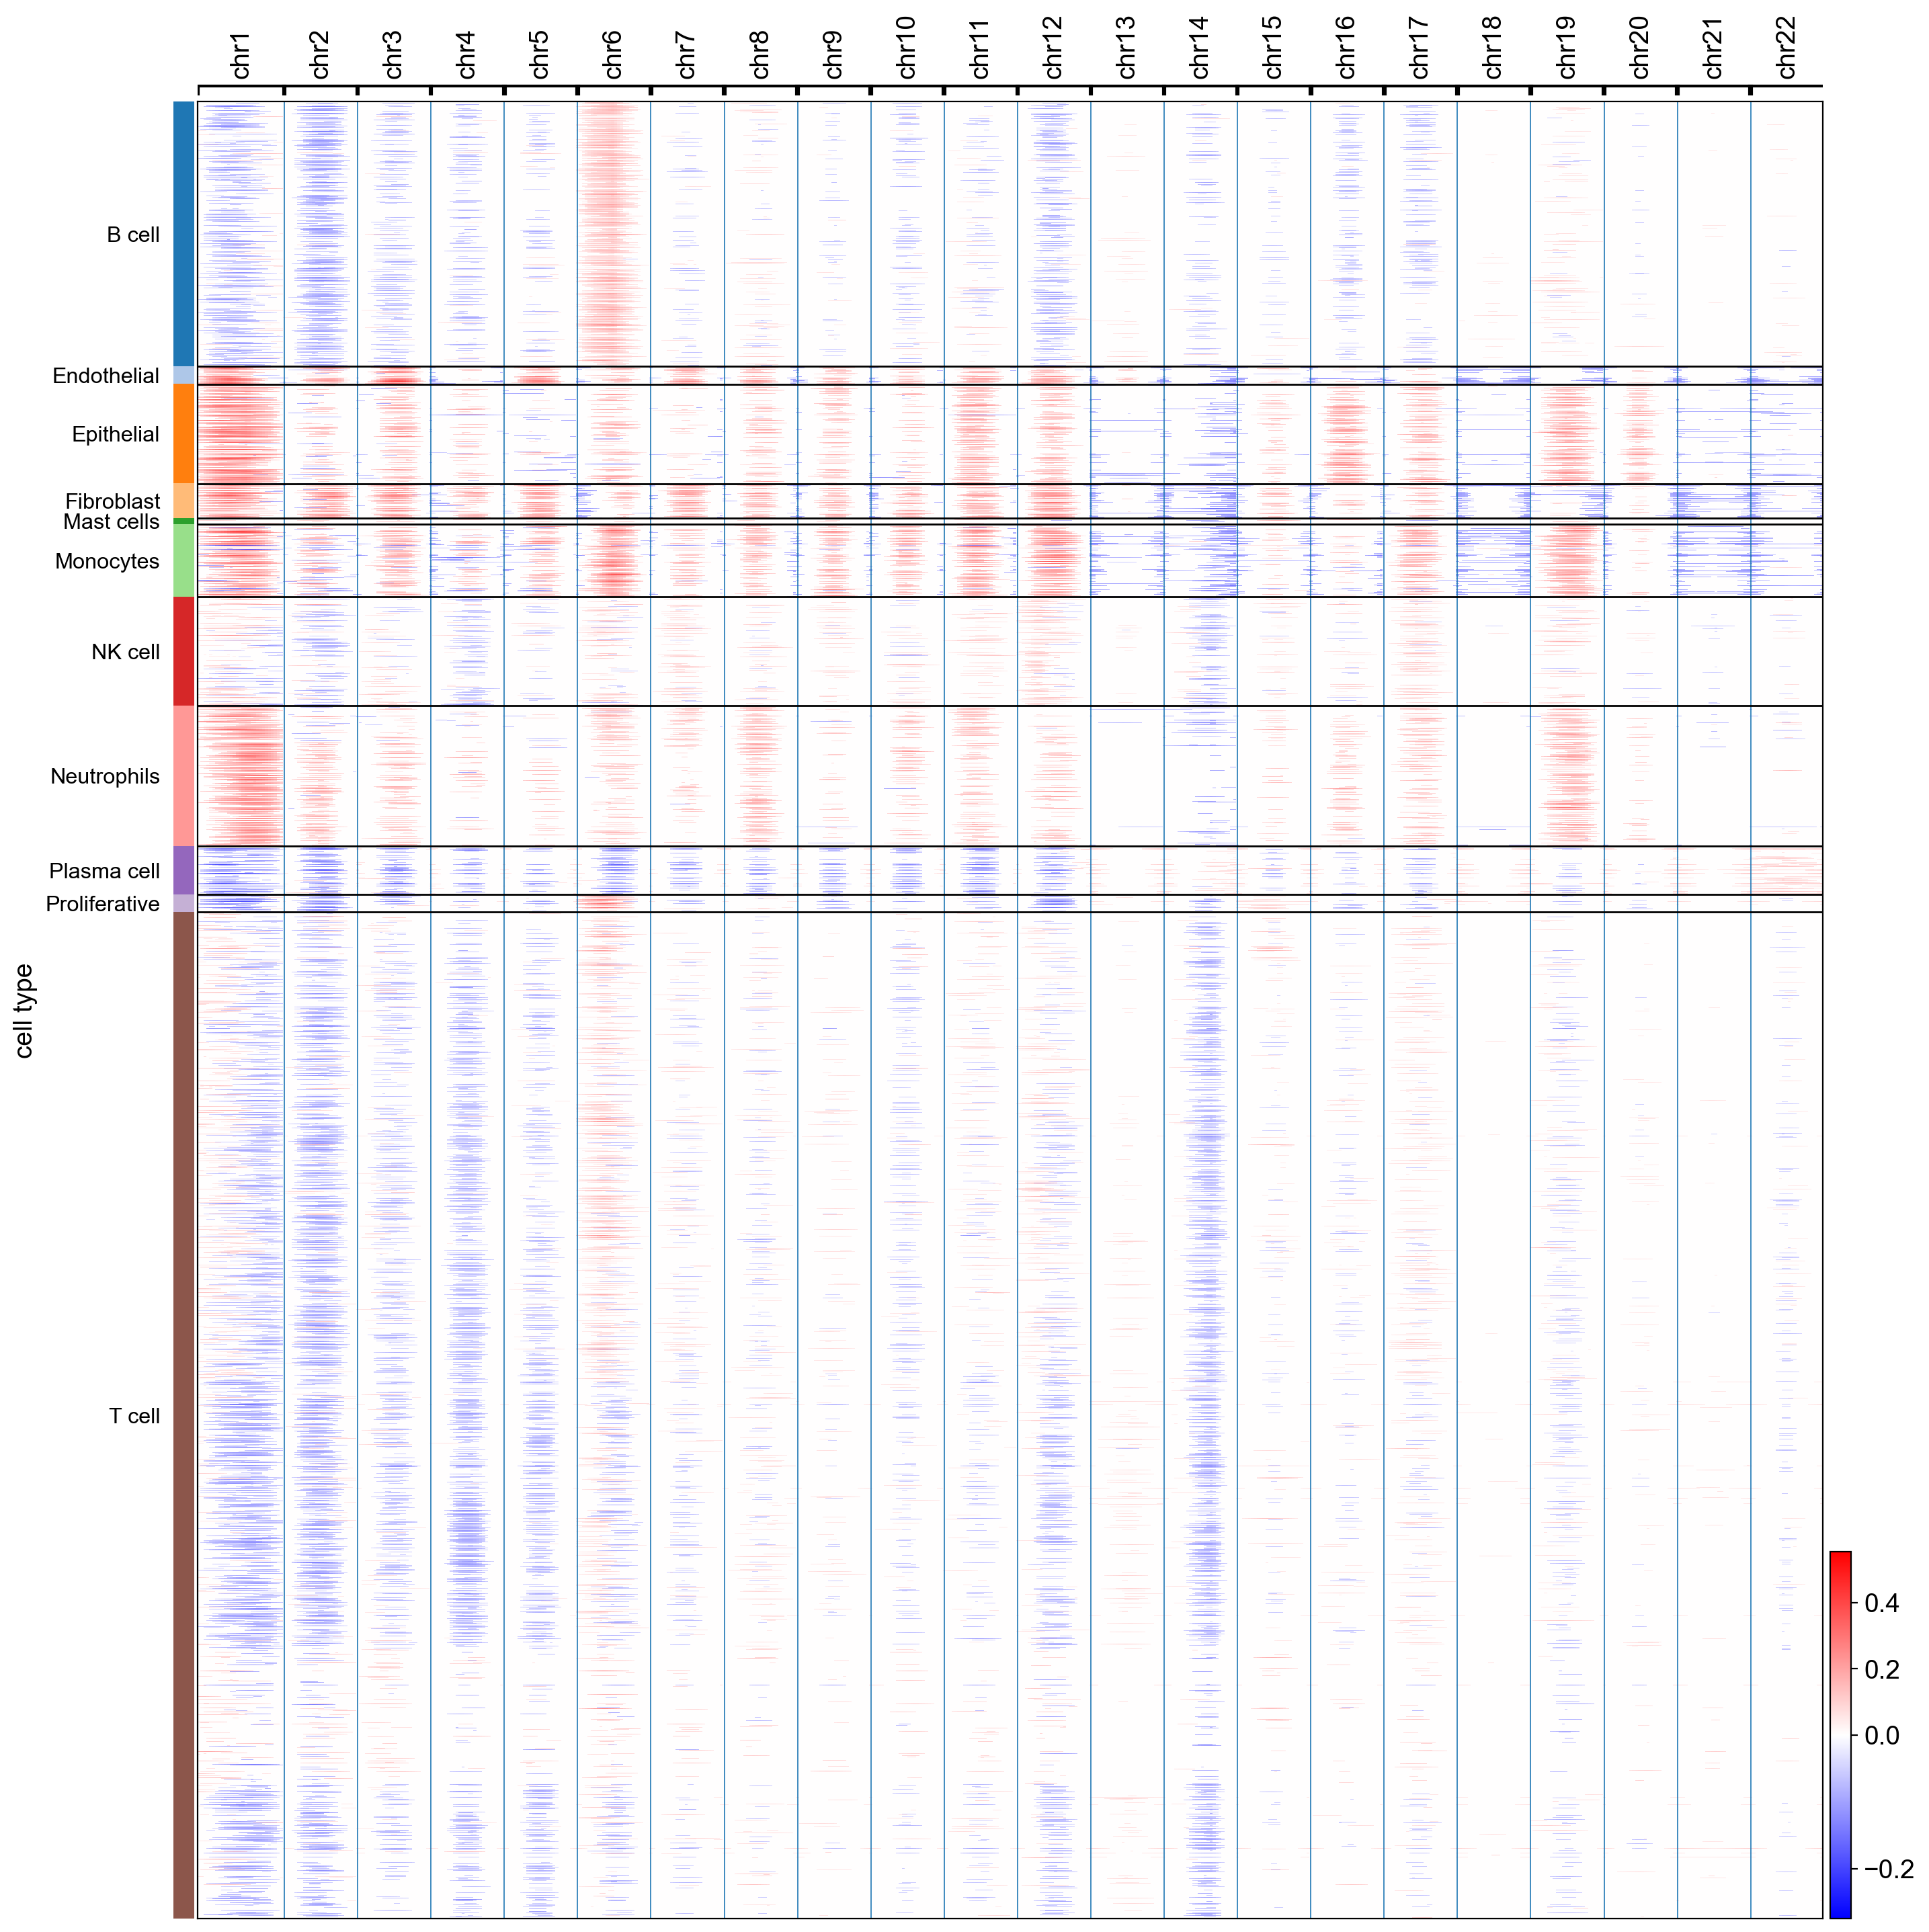

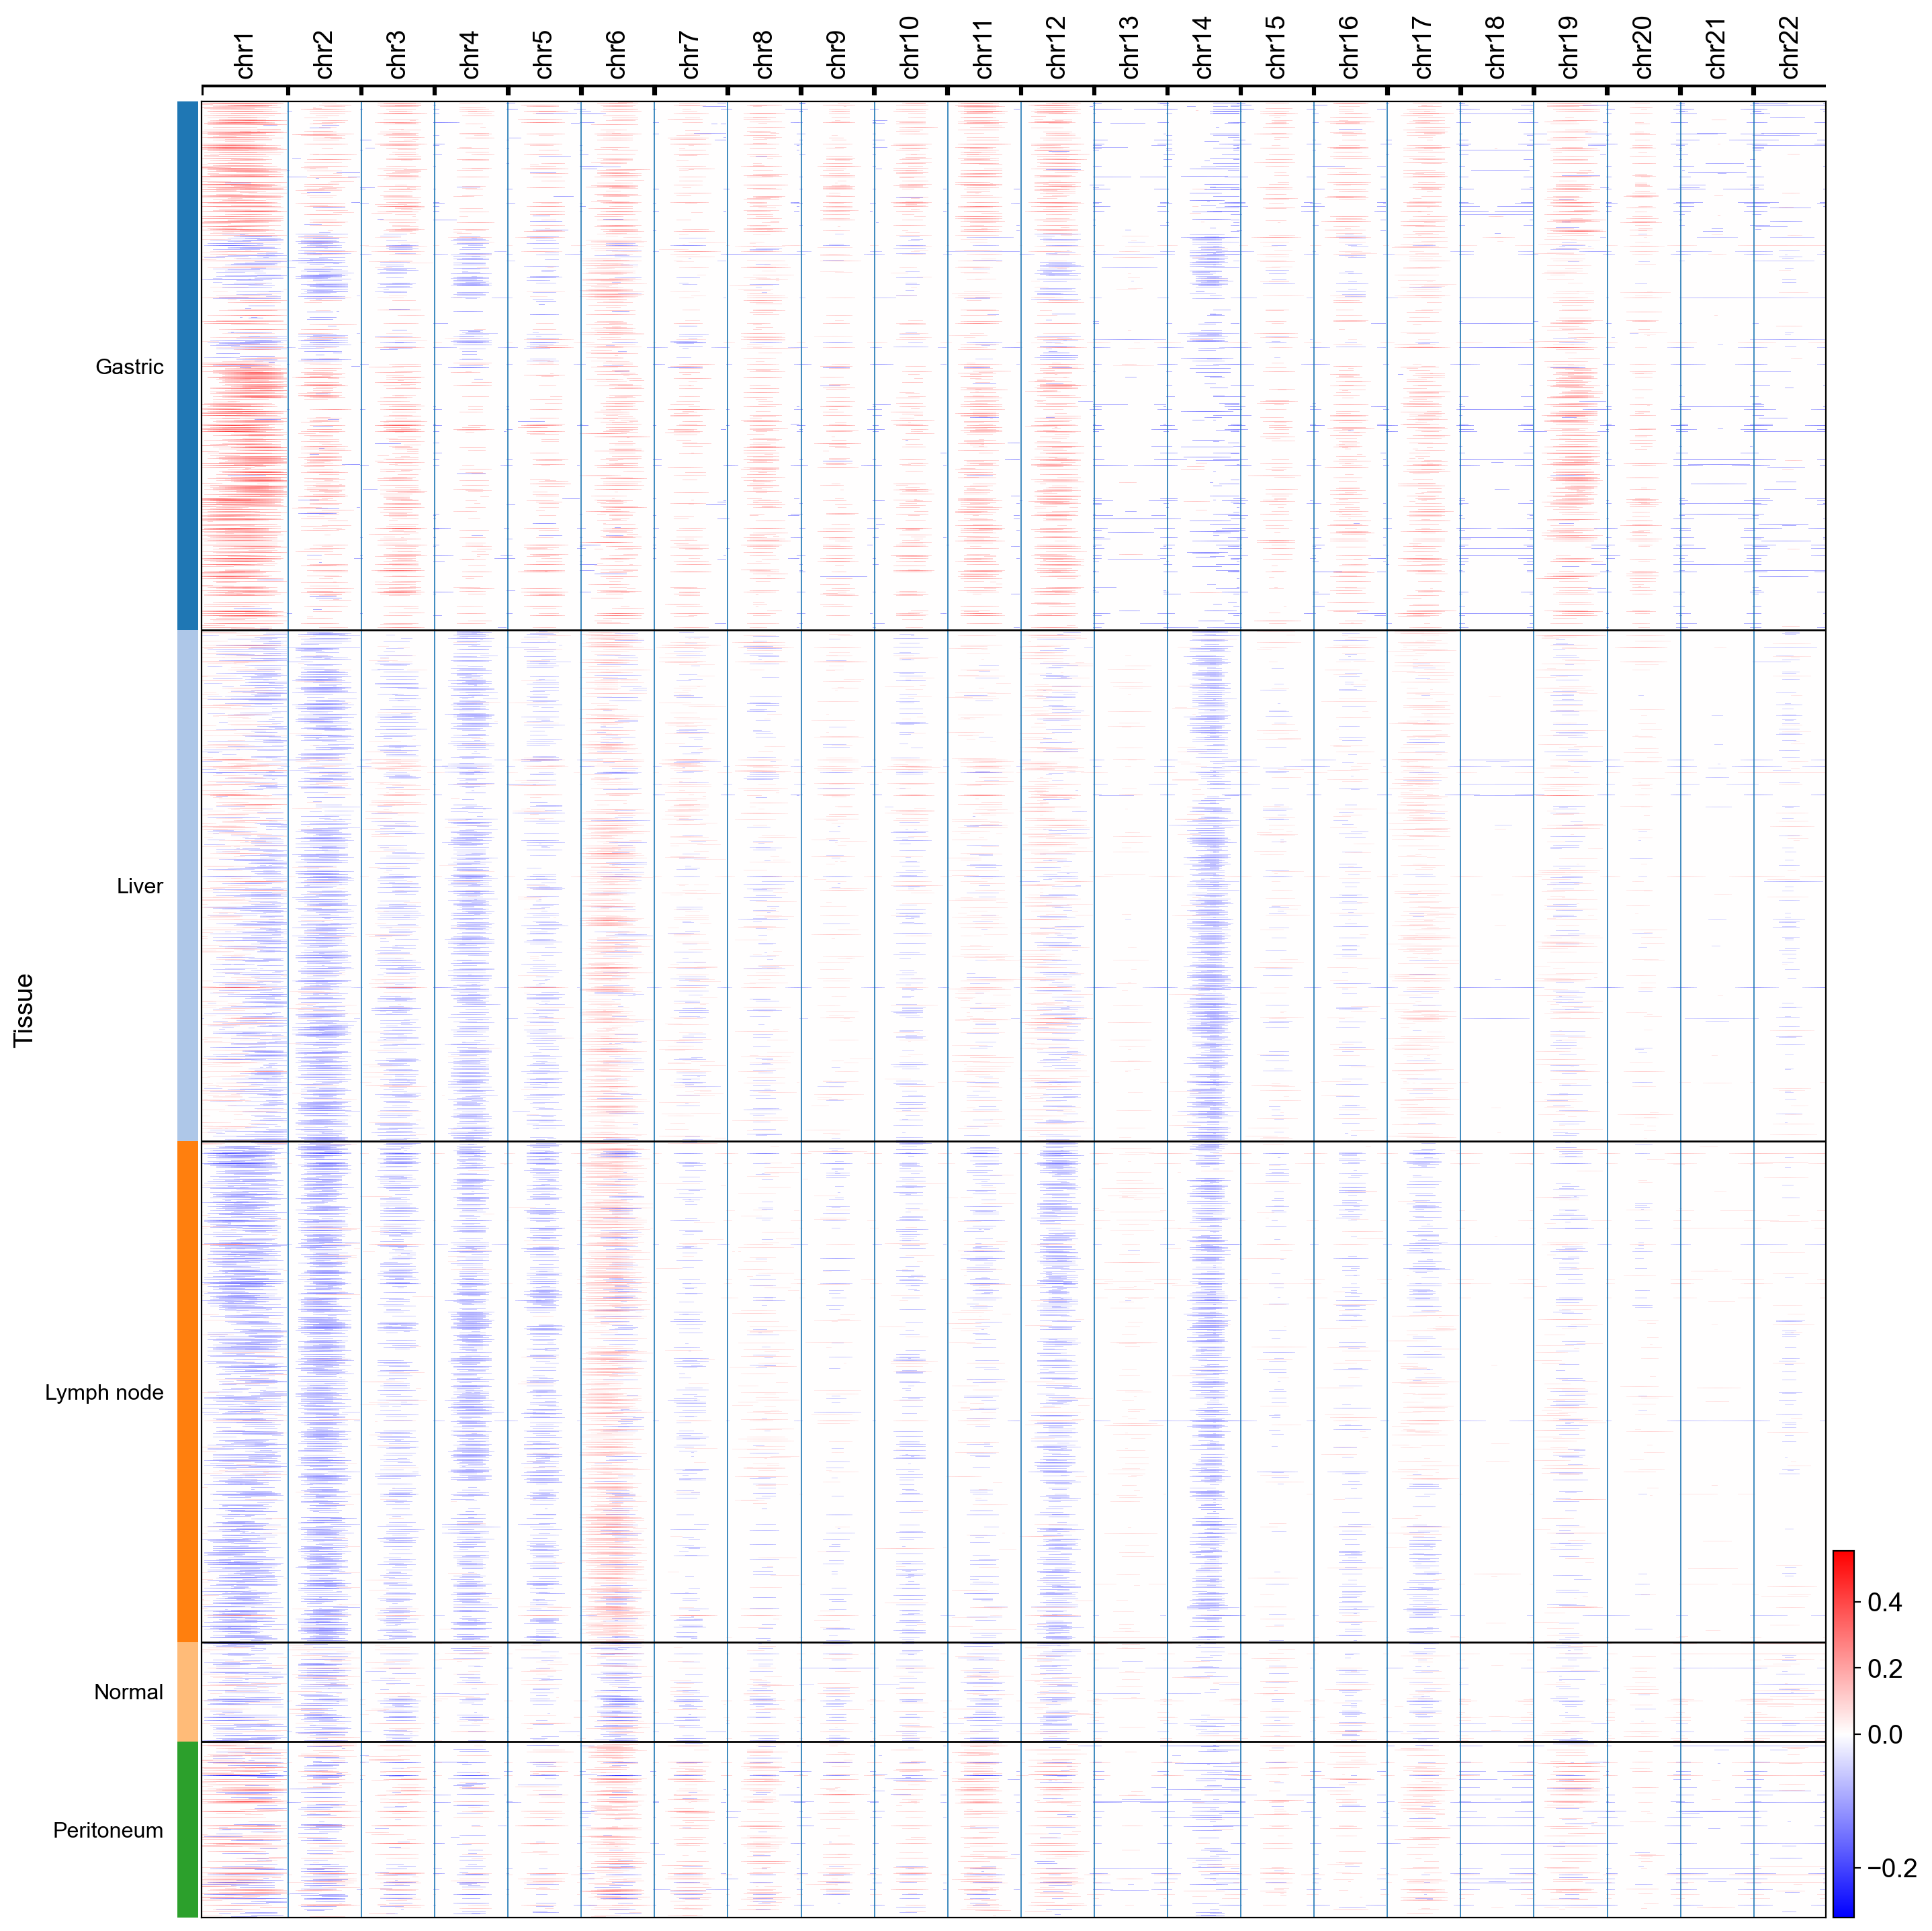

In [100]:
cnv.pl.chromosome_heatmap(adata, groupby=["cell type"],figsize=(16,18))
cnv.pl.chromosome_heatmap(adata, groupby=["Tissue"],figsize=(16,18))

In [67]:
#通过CNV剖面图聚类和识别肿瘤细胞
cnv.tl.pca(adata)
cnv.pp.neighbors(adata,n_pcs=40, n_neighbors= 25)
cnv.tl.leiden(adata,resolution=0.3)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['cnv_neighbors']`
    `.obsp['cnv_neighbors_distances']`, distances for each pair of neighbors
    `.obsp['cnv_neighbors_connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'cnv_leiden', the cluster labels (adata.obs, categorical) (0:00:17)


In [68]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


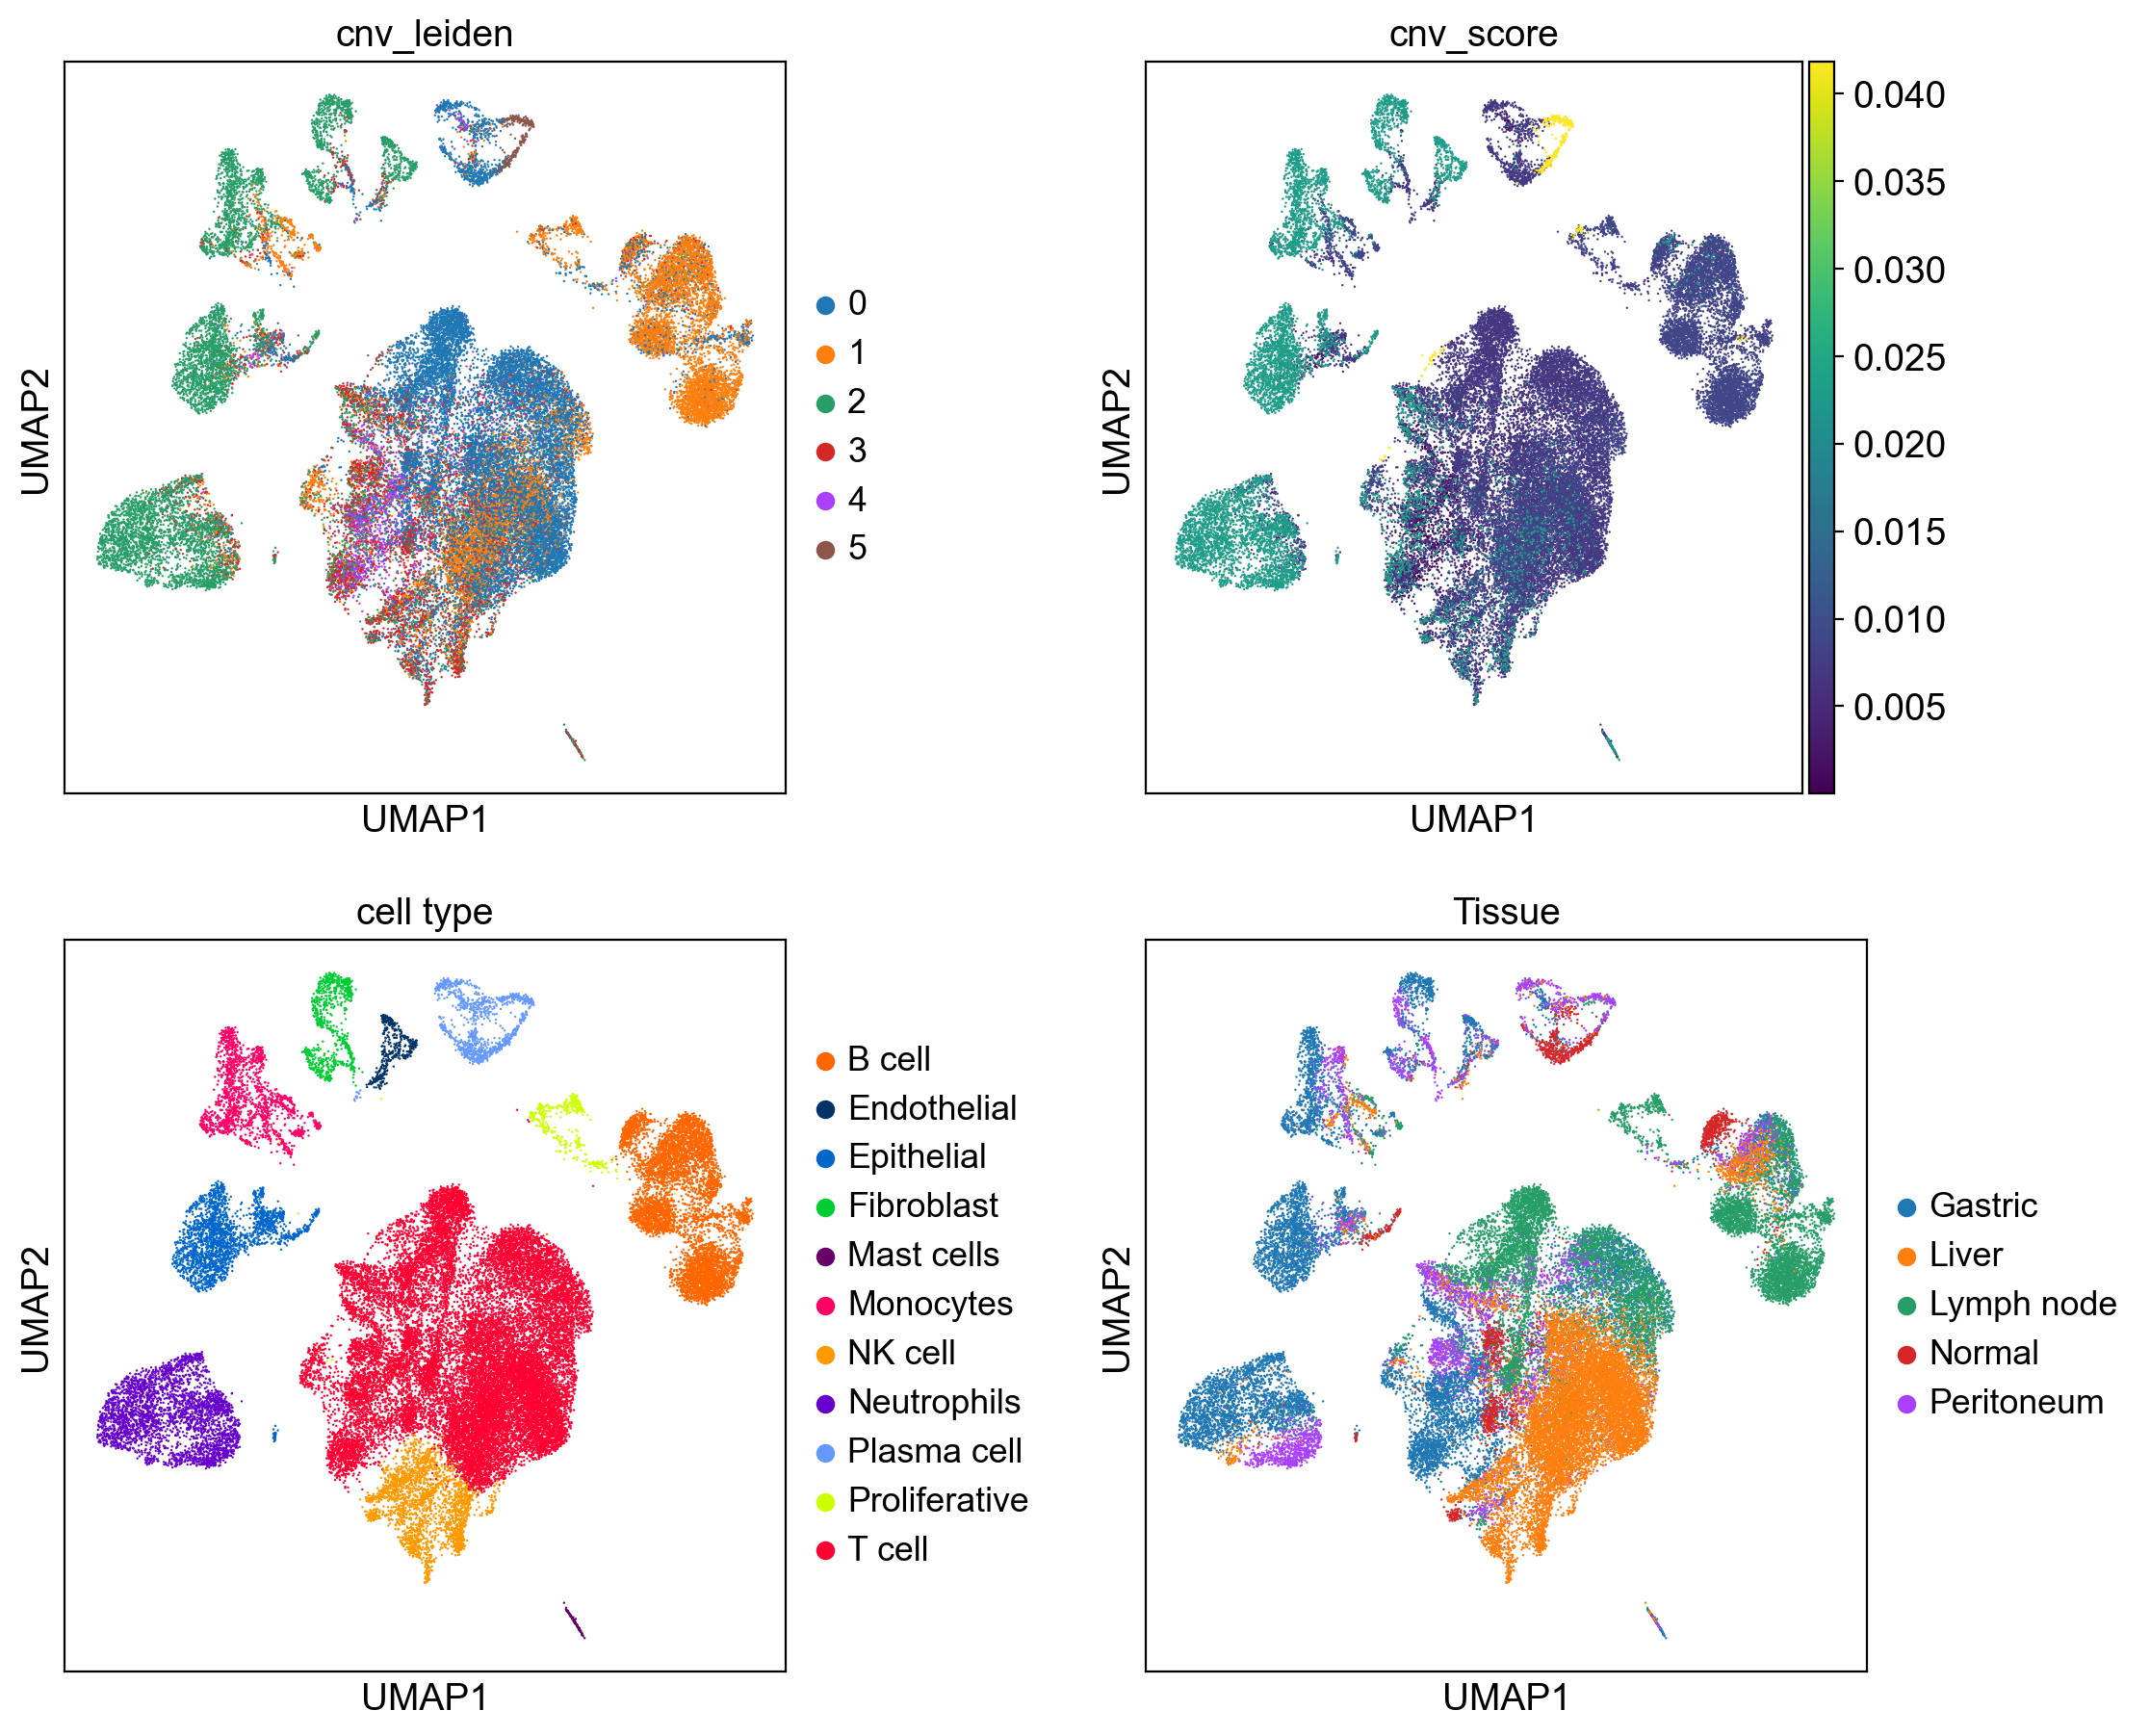

In [108]:
sc.settings.set_figure_params(dpi=100,dpi_save=600)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
sc.pl.umap(adata, color="cnv_leiden",ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score",cmap='viridis',ax=ax2, show=False)
sc.pl.umap(adata, color="cell type", ax=ax3, show=False)
sc.pl.umap(adata, color="Tissue", ax=ax4)

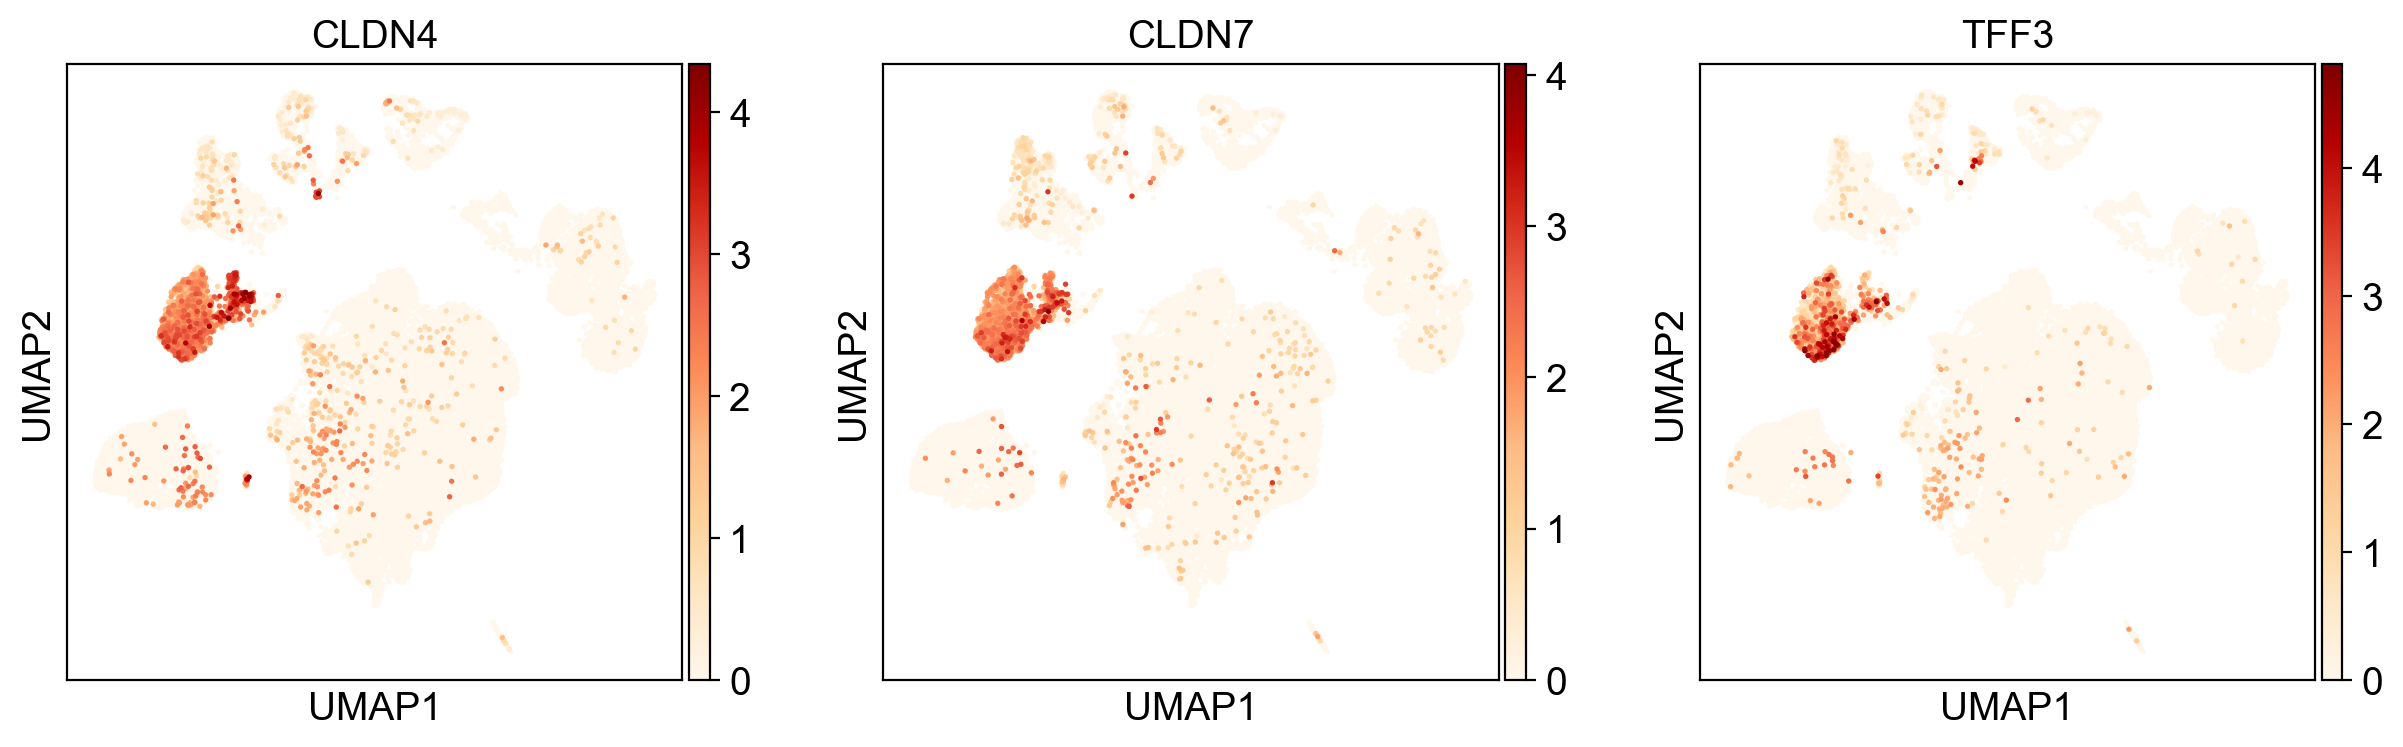

In [109]:
markers = ['CLDN4','CLDN7','TFF3']#Malignant
sc.pl.umap(adata,color=markers,ncols=3,cmap='OrRd',size=15,legend_fontsize=12)

In [110]:
#肿瘤细胞分类
#根据这些观察结果，我们现在可以将细胞分配给“肿瘤”或“正常”。为此，我们在adata.obs中添加了一个新列cnv_status
adata.obs["cnv_status"] = "Normal"
adata.obs.loc[
    adata.obs["cnv_leiden"].isin(["2", "5"]), "cnv_status"
] = "Malignant"

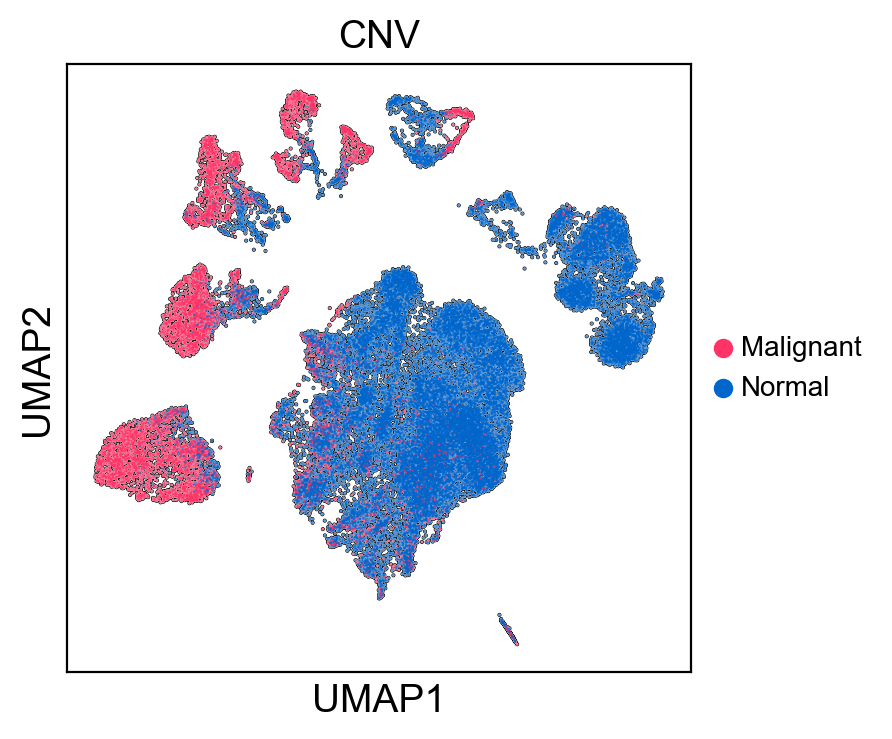

In [119]:
sc.pl.umap(adata, color="cnv_status",add_outline=True, legend_loc='right margin',
               legend_fontsize=10, legend_fontoutline= 1,frameon= True,palette=['#FF3366', '#0066CC'],title='CNV')

In [120]:
adata.write('./cache/scRNA_cnv.h5ad')